In [1]:
from Risk_Factor_Calculation import*

from WindPy import *
import numpy as np
import pandas as pd
from datetime import *
import talib as ta
import matplotlib.pyplot as plt

import math
from scipy import stats

import datetime
from openpyxl.reader.excel import load_workbook as lw
import pymysql
from pylab import *
from matplotlib.font_manager import FontProperties  
%matplotlib inline
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

Data extraction and processing 数据获取及处理
====

In [80]:
list={'code' : pd.Series(["510310.SH","511010.SH"]),
      'startdate' : pd.Series(["20130801", "20130801"]),
      'enddate': pd.Series(["20220930", "20220930"])}     
asset = pd.DataFrame(list)  

def download_data_from_wind():
    global table
    table = pd.DataFrame(columns = ['time','code','open','high','low','close'])

    list=pd.Series(["510310.SH","511010.SH","518880.SH","131801.SZ"])
    asset = pd.DataFrame(list,columns=['code'])
    
    for i in range(len(asset)):
        data = pd.DataFrame()
        indicators = "open,high,low,close"
        startdate = "20130801" #回测起始时间，可自行修改
        enddate = "20220930" #回测结束时间，可自行修改
        vol = w.wsd(asset.code[i], fields = indicators, startdate = startdate, enddate = enddate, option = "unit=1;traderType=1")
        data['time'] = vol.Times
        data['code'] = [vol.Codes[0] for j in range(len(data['time']))]
        data['open'] = vol.Data[0]
        data['high'] = vol.Data[0]
        data['low'] = vol.Data[0]
        data['close'] = vol.Data[0]
        #data['interest'] = [0 for j in range(len(data['time']))] #待改
        #data['return'] = [0] + [((data['price'][j]+data['interest'][j])/(data['price'][j-1]+data['interest'][j-1])-1)for j in range(1,len(data['price']))]
        
        table = pd.concat([table,data],axis = 0,ignore_index = True)

        path = "C:/Users/DELL/Desktop/策略代码/data_eb_M.xlsx"
        table.to_excel(path,header=True)

download_data_from_wind()

In [81]:
#数据导入
path = "C:/Users/DELL/Desktop/策略代码/data_eb_M.xlsx"
data = pd.read_excel(path) #读取数据
data.set_index(data["time"], inplace=True) #设置数据索引为交易日
#删去有空白的行
#newdata=data.dropna(axis=0,how='any')

#HS300ETF = pd.DataFrame(data[data["code"] == '510310.SH']["close"].astype(float)) #沪深300ETF专属数据结构。仅保留收盘价格
#GZ5yETF = pd.DataFrame(data[data["code"] == '511010.SH']["close"].astype(float)) #国债ETF专属数据结构。仅保留收盘价格

#td_dates = HS300ETF.index #记录交易日信息，方便以后进行查找
#n = len(td_dates) #记录回溯交易日天数

data.set_index(data["time"], inplace=True) #设置数据索引为交易日
tickers = ["510310.SH","511010.SH","518880.SH",'131801.SZ']

HS300ETF = pd.DataFrame(data[data["code"] == '510310.SH']["close"].astype(float)) #沪深300ETF专属数据结构。仅保留收盘价格
GZ5yETF = pd.DataFrame(data[data["code"] == '511010.SH']["close"].astype(float)) #国债ETF专属数据结构。仅保留收盘价格
GoldETF = pd.DataFrame(data[data["code"] == '518880.SH']["close"].astype(float)) #黄金ETF专属数据结构。仅保留收盘价格
R_001 = pd.DataFrame(data[data["code"] == '131801.SZ']["close"].astype(float)) #黄金ETF专属数据结构。仅保留收盘价格

td_dates = HS300ETF.index #记录交易日信息，方便以后进行查找
n = len(td_dates)#记录回溯交易日天数

## Module2: calculate return计算收益率 ##

In [83]:
#######################
## Module2: 计算收益率 ##
#######################
pd.set_option('mode.chained_assignment', None)

# 创建收益率序列
HS300ETF['RETURN'] = 0 #创建收益率序列
GZ5yETF['RETURN'] = 0 #创建收益率序列
GoldETF['RETURN'] = 0 #创建收益率序列
R_001['RETURN'] = 0
HS300ETF['RETURN'].astype(float)#设定格式为浮点
GZ5yETF['RETURN'].astype(float)#设定格式为浮点
GoldETF['RETURN'].astype(float)#设定格式为浮点
R_001['RETURN'].astype(float)#设定格式为浮点

# 计算收益率
HS300ETF["RETURN"][td_dates[1:]] = np.array(HS300ETF["close"][td_dates[1:]]) / np.array(HS300ETF["close"][td_dates[:-1]]) - 1 #计算HS300ETF日收益率
GZ5yETF["RETURN"][td_dates[1:]] = np.array(GZ5yETF["close"][td_dates[1:]]) / np.array(GZ5yETF["close"][td_dates[:-1]]) - 1 #计算GZ5yETF日收益率
GoldETF["RETURN"][td_dates[1:]] = np.array(GoldETF["close"][td_dates[1:]]) / np.array(GoldETF["close"][td_dates[:-1]]) - 1 #计算GZ5yETF日收益率
R_001["RETURN"][td_dates[1:]] = np.array(R_001["close"][td_dates[1:]])/100/365

# 将收益率序列单独存储至returns
returns = pd.DataFrame({'510310.SH':HS300ETF["RETURN"], '511010.SH':GZ5yETF["RETURN"], '518880.SH':GoldETF["RETURN"], '131801.SZ':R_001["RETURN"]},
                       index= td_dates)

#print(returns.head())  #打印表头查看


## Module 3: Moving average(MA) curve 计算移动平均曲线值 ##

In [84]:
###############################
## Module 3: 计算移动平均曲线值 ##
###############################
def MA(price_series, t, output_type = 'DataFrame'):
    """
    t: 回溯窗口长度
    return_series: 收益率序列
    type: 输出序列格式。支持list格式与pd.DataFrame格式
    """
    td_dates = price_series.index
    return_series = price_series.tolist()
    n = len(price_series)
    MA = []
    for i in range(t, n):
        MA.append(np.mean(price_series[i-t:i]))

    if output_type.upper() == "LIST":
        return MA
    elif output_type.upper() == "DATAFRAME":
        return pd.DataFrame({"MA":MA}, index = td_dates[t:n])
    else:
        return MA


t = 120
HS300ETF_MA = MA(price_series = HS300ETF["close"], t = t, output_type = 'DataFrame')
GZ5yETF_MA = MA(price_series = GZ5yETF["close"], t = t, output_type = 'DataFrame')
GoldETF_MA = MA(price_series = GoldETF["close"], t = t, output_type = 'DataFrame')


## Module 4: strategies backtesting-net value\return  
各策略净值与收益率计算

nv_strategy_balance多资产均衡配置策略：  
总资产分别配置于股票-债券-商品-现金这四类资产，即四类资产各占25%。以每日作为调仓周期为例（可根据投资资金量与个人的投资风格进行调整），对于股票、债券和商品这三类资产，若前一交易日的收盘价格站上120日均线，则认为该类资产走强，可以进入该类资产多头，并配置25%的仓位；否则，则清仓该类资产，转而持有现金。  
nv_strategy_stock多资产偏股型策略：  
与多资产均衡型策略唯一差别就在于投资于股票类资产的权重。当股票的多头信号出现时，则配置50%的股票资产，否则清仓股票资产，并持有现金资产；当债券或商品类多头信号出现时，则配置25%的该类别资产，否则清仓该类资产，并持有现金。  
rategy_bond多资产偏债型策略：  
与偏股型策略的思想一样，唯一的区别就是将50%的高权重配置于债权类资产而非股票类。

In [89]:
#################################
## Module 4: 各策略净值与收益率计算 ##
#################################
nv_HS300ETF = [1]  #记录全仓股票策略净值
nv_GZ5yETF = [1]  #记录全仓债券策略净值
nv_GoldETF = [1]
nv_Cash = [1]
r_HS300ETF = []
r_GZ5yETF = []
r_GoldETF = []
r_Cash = []

nv_strategy_balance = [1]
r_strategy_balance = []
nv_strategy_stock = [1]
r_strategy_stock = []
nv_strategy_bond = [1]
r_strategy_bond = []
#nv_strategy_Gold = [1]
#r_strategy_Gold = []

for i in range(n):
    nv_HS300ETF.append( nv_HS300ETF[i] *(1 + returns['510310.SH'][td_dates[i]]))
    nv_GZ5yETF.append( nv_GZ5yETF[i] *(1 + returns['511010.SH'][td_dates[i]]))
    nv_GoldETF.append( nv_GoldETF[i] *(1 + returns['518880.SH'][td_dates[i]]))
    nv_Cash.append( nv_Cash[i] *(1 + returns['131801.SZ'][td_dates[i]]))
    r_HS300ETF.append(returns['510310.SH'][td_dates[i]])
    r_GZ5yETF.append(returns['511010.SH'][td_dates[i]])
    r_GoldETF.append(returns['518880.SH'][td_dates[i]])
    r_Cash.append(returns['131801.SZ'][td_dates[i]])

    # balance Strategy
    w_HS300ETF = 0.25
    w_GZ5yETF = 0.25
    w_GoldETF = 0.25
    w_cash = 0.25

    if td_dates[i] in HS300ETF_MA.index:
        if HS300ETF["close"][td_dates[i]] < HS300ETF_MA["MA"][td_dates[i]]:
            w_HS300ETF = 0
            w_cash += 0.25
        if GZ5yETF["close"][td_dates[i]] < GZ5yETF_MA["MA"][td_dates[i]]:
            w_GZ5yETF = 0
            w_cash += 0.25
        if GoldETF["close"][td_dates[i]] < GoldETF_MA["MA"][td_dates[i]]:
            w_GoldETF = 0
            w_cash += 0.25
        r_strategy_balance.append(w_HS300ETF * returns[tickers[0]][td_dates[i]] +
                                  w_GZ5yETF * returns[tickers[1]][td_dates[i]] +
                                  w_GoldETF * returns[tickers[2]][td_dates[i]] +
                                  w_cash * returns[tickers[3]][td_dates[i]])
        nv_strategy_balance.append(nv_strategy_balance[i] * (1 + r_strategy_balance[i]))

        r_strategy_stock.append((w_HS300ETF + 0.25) * returns[tickers[0]][td_dates[i]] +
                                  w_GZ5yETF * returns[tickers[1]][td_dates[i]] +
                                  w_GoldETF * returns[tickers[2]][td_dates[i]] +
                                (w_cash - 0.25) * returns[tickers[3]][td_dates[i]])
        nv_strategy_stock.append(nv_strategy_stock[i] * (1 + r_strategy_stock[i]))

        r_strategy_bond.append(w_HS300ETF * returns[tickers[0]][td_dates[i]] +
                                (w_GZ5yETF + 0.25) * returns[tickers[1]][td_dates[i]] +
                                w_GoldETF * returns[tickers[2]][td_dates[i]] +
                                (w_cash - 0.25) * returns[tickers[3]][td_dates[i]])
        nv_strategy_bond.append(nv_strategy_bond[i] * (1 + r_strategy_bond[i]))

    else:
        nv_strategy_balance.append(nv_strategy_balance[i])
        r_strategy_balance.append(0)

        nv_strategy_stock.append(nv_strategy_stock[i])
        r_strategy_stock.append(0)

        nv_strategy_bond.append(nv_strategy_bond[i])
        r_strategy_bond.append(0)
        
        
        
        


## Module 5: Results summary and visualization 
汇总各策略净值信息，并计算其风险及收益情况

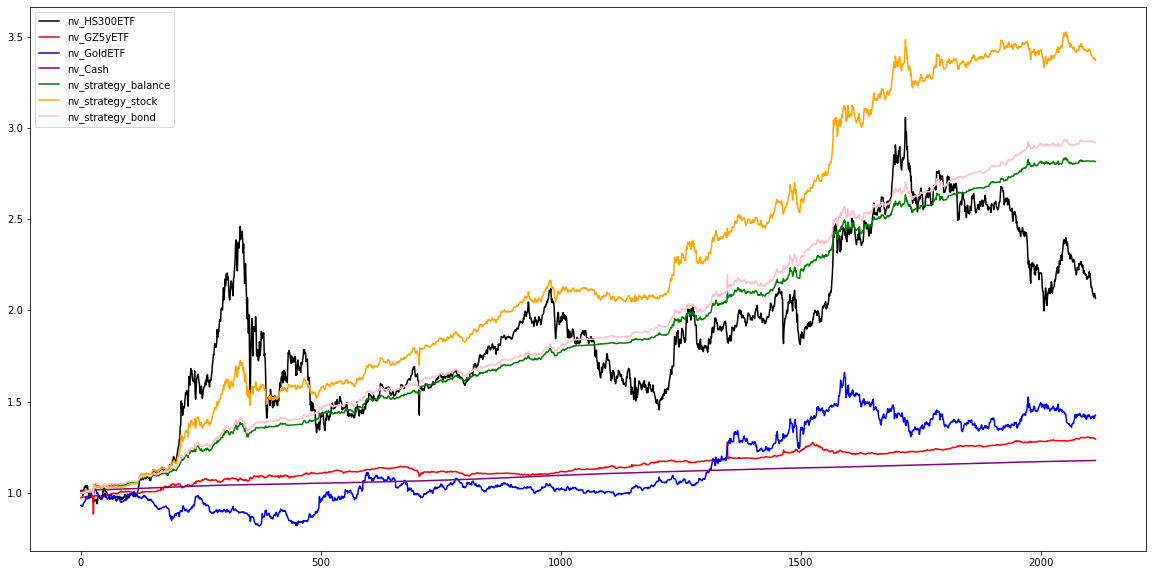

In [203]:

################################
## Module 6: 绘制各策略净值走势图 ##
################################
plt.figure(figsize=(20, 10))
plt.plot(nv_HS300ETF[t:], label = "nv_HS300ETF", color = "black")
plt.plot(nv_GZ5yETF[t:], label = "nv_GZ5yETF", color = "red")
plt.plot(nv_GoldETF[t:], label = "nv_GoldETF", color = "blue")
plt.plot(nv_Cash[t:], label="nv_Cash", color="purple")
plt.plot(nv_strategy_balance[t:], label="nv_strategy_balance", color="green")
plt.plot(nv_strategy_stock[t:], label="nv_strategy_stock", color="orange")
plt.plot(nv_strategy_bond[t:], label="nv_strategy_bond", color="pink")
plt.legend()
plt.show()

In [279]:

# Step 3: 计算各策略日波动率
sigmas = []
sigmas.append(np.std(r_HS300ETF[t:n-t]))
sigmas.append(np.std(r_GZ5yETF[t:n-t]))
sigmas.append(np.std(r_GoldETF[t:n-t]))
sigmas.append(np.std(r_Cash[t:n-t]))
sigmas.append(np.std(r_strategy_balance[t:n-t]))
sigmas.append(np.std(r_strategy_stock[t:n-t]))
sigmas.append(np.std(r_strategy_bond[t:n-t]))


# Step 4: 计算各策略日收益率
mean_returns = []
mean_returns.append(np.mean(r_HS300ETF[t:n-t]))
mean_returns.append(np.mean(r_GZ5yETF[t:n-t]))
mean_returns.append(np.mean(r_GoldETF[t:n-t]))
mean_returns.append(np.mean(r_Cash[t:n-t]))
mean_returns.append(np.mean(r_strategy_balance[t:n-t]))
mean_returns.append(np.mean(r_strategy_stock[t:n-t]))
mean_returns.append(np.mean(r_strategy_bond[t:n-t]))


# Step 5: 计算各策略日夏普比率
sharpe_ratios = []
for i in range(len(sigmas)):
    sharpe_ratios.append(mean_returns[i] / sigmas[i])
    

#计算最大回撤
W={"time":td_dates[t-1:],"HS300ETF":nv_HS300ETF[t:],"GZ5yETF":nv_GZ5yETF[t:],"GoldETF":nv_GoldETF[t:],"Cash":nv_Cash[t:],"strategy_balance":nv_strategy_balance[t:],"strategy_stock":nv_strategy_stock[t:],"strategy_bond":nv_strategy_bond[t:]}
D=pd.DataFrame(W)
#D.set_index(D["time"], inplace=True) #设置数据索引为交易日
#D.index = pd.to_datetime(D['time'])    
#path = "C:/Users/DELL/Desktop/策略代码/D.xlsx"
#D.to_excel(path,header=True)

def MaxDrawdown(return_list):
    i = np.argmax((np.maximum.accumulate(return_list)- return_list))# 最大回撤结束的位置 最低的那个位置 np.argmax作用：取出数组中最大值对应的索引
    if i == 0:
        j= 0
    else:
        j = np.argmax(return_list[:i])# 回撤开始的位置 最高的那个点

    maxdrawdown = return_list[j] - return_list[i] # 最大回撤
    maxdrawdown_rate = (return_list[j] - return_list[i]) / return_list[j] # 最大回撤率
    drawdown_days = i - j # 回撤持续天数
    return maxdrawdown,j,i,i-j

#maxdrawdown= MaxDrawdown(D['strategy_balance'])


group1=(pd.DataFrame(MaxDrawdown(D['HS300ETF']))).T
group2=(pd.DataFrame(MaxDrawdown(D['GZ5yETF']))).T
group3=(pd.DataFrame(MaxDrawdown(D['GoldETF']))).T
group4=(pd.DataFrame(MaxDrawdown(D['Cash']))).T
group5=(pd.DataFrame(MaxDrawdown(D['strategy_balance']))).T
group6=(pd.DataFrame(MaxDrawdown(D['strategy_stock']))).T
group7=(pd.DataFrame(MaxDrawdown(D['strategy_bond']))).T
G=pd.concat([group1,group2,group3,group4,group5,group6,group7])
col=['max_drawdown','startdate','enddate','drawdown_day']
G.columns=col

# Step 6: 打印结果，并绘制净值走势图
outcome1 = pd.DataFrame({'mean_returns': mean_returns, 'sigmas': sigmas, 'sharpe_ratios': sharpe_ratios}, index = ['纯股','纯债','商品','现金' ,'资产均衡','偏股','偏债'])
outcome = pd.merge(outcome1,G,on=[outcome1.index])
outcome

,key_0,mean_returns,sigmas,sharpe_ratios,max_drawdown,startdate,enddate,drawdown_day
0,纯股,0.000532,0.016414,0.032432,1.130682,332.0,491.0,159.0
1,纯债,0.000149,0.004470,0.033246,0.102645,19.0,26.0,7.0
2,商品,0.000260,0.008522,0.030505,0.352431,1591.0,1729.0,138.0
3,现金,0.000073,0.000030,2.394948,0.000000,0.0,0.0,0.0
4,资产均衡,0.000522,0.003358,0.155353,0.096852,1718.0,1732.0,14.0
5,偏股,0.000637,0.006477,0.098297,0.263884,1718.0,1733.0,15.0
6,偏债,0.000541,0.003798,0.142383,0.098259,1718.0,1732.0,14.0


D:\PYTHON\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\PYTHON\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\PYTHON\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\PYTHON\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25764 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\PYTHON\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 26368 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\PYTHON\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\PYTHON\lib\site-packages\matplotlib\backe

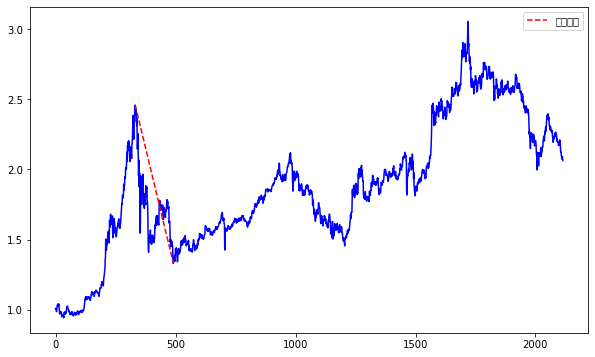

In [285]:
startdate = outcome.startdate[[0]].values[0] #开始回撤的日期
enddate = outcome.enddate[[0]].values[0] #结束回撤的日期
start_net_value = D[D.index == startdate]['HS300ETF'].values[0] #开始回撤的净值
end_net_value = D[D.index == enddate]['HS300ETF'].values[0] #结束回撤的净值
plt.figure(figsize=(10,6))
plt.plot(D['HS300ETF'],color='b')
plt.plot([startdate, enddate], [start_net_value, end_net_value], linestyle='--', label="最大回撤",color='r')
plt.legend()